Cells that are commented out ( that is, starting with `#` ) are supposed to be run once, if the cells underneath are not running correctly.

This notebook shows how to do the stuff shown in [this blog post](https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6) having the julia kernel launched.

In [1]:
# using Pkg
# pkg"add PyCall RCall"

This is loading the `PyCall` and `RCall` packages.

In [2]:
using PyCall,RCall;

┌ Info: Recompiling stale cache file /usr/home/christ/.julia/compiled/v1.1/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184


We can inspect the names exported by a Package with the `names` function. We use the `show` function to view the full output instead of the truncated one.

In [41]:
show(names(RCall))

Symbol[Symbol("@R_str"), Symbol("@rget"), Symbol("@rimport"), Symbol("@rlibrary"), Symbol("@rput"), Symbol("@var_str"), :CharSxp, :ClosSxp, :CplxSxp, :EnvSxp, :IntSxp, :LangSxp, :LglSxp, :ListSxp, :NilSxp, :RCall, :RObject, :RealSxp, :S4Sxp, :StrSxp, :Sxp, :VecSxp, :anyna, :attributes, :getattrib, :getclass, :getnames, :globalEnv, :isna, :isnull, :rcall, :rcopy, :reval, :rimport, :rlang, :robject, :rparse, :rprint, :setattrib!, :setclass!, :setnames!, :sexp]

The documentation string of a function can be viewed by prefixing a `?`

In [42]:
?@rput

Copies variables from Julia to R using the same name.


## Using Python from Julia 

Python code can be written via the python string macro ( `@py_str` ) as shown below.

In [5]:
py"""
def fib(n):
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y
"""

Python libraries can be imported in julia via the `@pyimport` macro.

In [26]:
@pyimport numpy

In [4]:
#Pkg.add("PyPlot");

In [5]:
using PyPlot # that's using matplotlib from julia

┌ Info: Recompiling stale cache file /usr/home/christ/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


The multiline string version ( `py""" ... """` ) does return `nothing` whereas the inline string version  ( `py" ... "` ) returns the last expression.

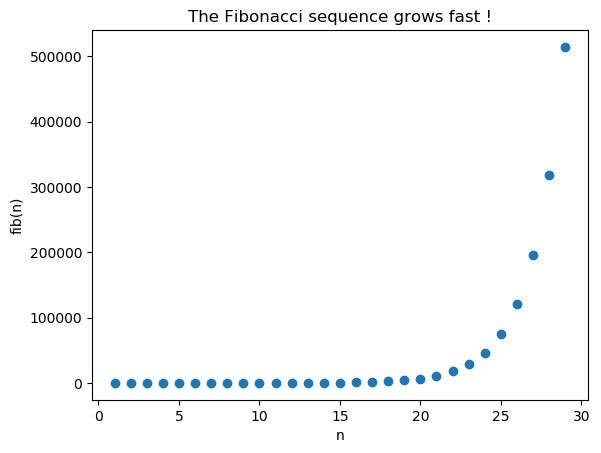

In [67]:
py"""
import numpy as np
X = np.arange(1,30)
Y = np.array([fib(x) for x in X])
ax.scatter(X, Y)
ax.set(xlabel='n', ylabel='fib(n)',
       title='The Fibonacci sequence grows fast !')
"""
X, Y = py"X", py"Y"
function fibplot( x, y )
    scatter( x, y )
    xlabel("n")
    ylabel("fib(n)")
    title("The Fibonacci sequence grows fast !")
end
fibplot( X, Y );

## Using R from Julia
Here we are passing the arrays that we created with python and plotted in Julia to R

In [47]:
@rput X Y;

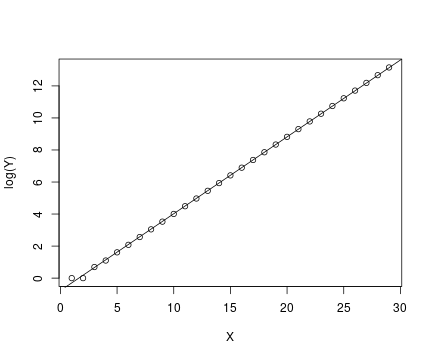

┌ Warning: RCall.jl: Warning in abline(my_summary) :
│   only using the first two of 8 regression coefficients
└ @ RCall /usr/home/christ/.julia/packages/RCall/29zDq/src/io.jl:113


In [49]:
R"""
my_summary = summary(lm(log(Y)~X))
val <- my_summary$coefficients

plot(X, log(Y))
abline(my_summary)
""";

## Writing, compiling and executing C from Julia

And now we write and compile the same function in C and wrap it in Julia

In [63]:
# Pkg.add("Libdl")
using Libdl
C_code = """
int cfib(int n)
{
    int res=0;
    if (n <= 2){  
        res = 1;
    } else {
        res = cfib(n-1)+cfib(n-2);
    }
    return res;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_fib(X::Int) = ccall(("cfib", Clib), Int, (Int,), X)

c_fib (generic function with 1 method)

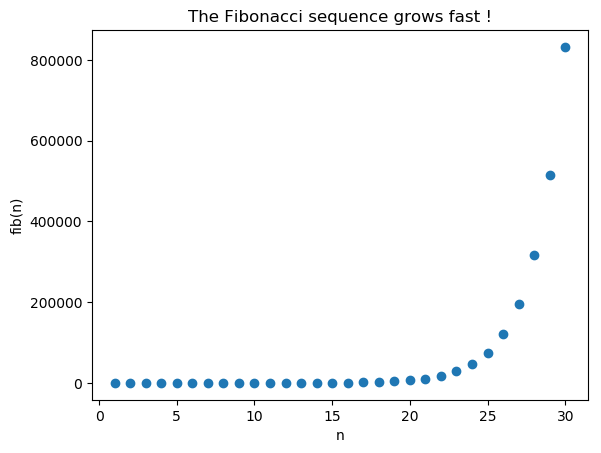

In [69]:
x = 1:30
y = [c_fib(ξ) for ξ in x] # ξ is \xi<tab>
fibplot( x, y );